#### Compute time weights to obtain the time mean from the monthly files

In [ ]:
weights=ds.time.dt.days_in_month/ds.time.dt.days_in_month.sum()
weights=weights.compute()
weights.sum()

In [20]:
# For 0.1 degree POP output
#ds['DZBC']=xr.broadcast(ds.dz,ds.TLONG)[0]
#ds['DZBC']=ds['DZBC'][-1,:,:]
#dzu, dzt = pop_tools.grid.calc_dzu_dzt(ds)
#ds['DZU']=dzu; ds['DZT']=dzt

# For 1 deg POP output
ds['DZU']=xr.broadcast(ds.dz,ds.TLONG)[0]; ds['DZT']=ds['DZU']

ds.DZT.attrs["long_name"] = "Thickness of T cells"
ds.DZT.attrs["units"] = "centimeter"
ds.DZT.attrs["grid_loc"] = "3111"
ds.DZU.attrs["long_name"] = "Thickness of U cells"
ds.DZU.attrs["units"] = "centimeter"
ds.DZU.attrs["grid_loc"] = "3221"

In [21]:
volfile=Path(common_path + 'popvol.nc')

if volfile.is_file():
    ds_VOL=xr.open_dataset(volfile)
    VOL=ds_VOL.VOL
else:    
# make sure we have the cell volumne for calculations
    VOL = (ds.DZT * ds.DXT * ds.DYT).compute()
    KMT = ds.KMT.compute()

    for j in tqdm(range(len(KMT.nlat))):
        for i in range(len(KMT.nlon)):
            k = KMT.values[j, i].astype(int)
            VOL.values[k:, j, i] = 0.0
    VOL.to_dataset(name='VOL').to_netcdf(volfile,mode='w')
            
ds["VOL"] = VOL

ds.VOL.attrs["long_name"] = "volume of T cells"
ds.VOL.attrs["units"] = "centimeter^3"

ds.VOL.attrs["grid_loc"] = "3111"

In [22]:
%%time

metrics = {
    ("X",): ["DXU", "DXT"],  # X distances
    ("Y",): ["DYU", "DYT"],  # Y distances
    ("Z",): ["DZU", "DZT"],  # Z distances
    ("X", "Y"): ["UAREA", "TAREA"],
}

# here we get the xgcm compatible dataset
gridxgcm, dsxgcm = pop_tools.to_xgcm_grid_dataset(
    ds,
    periodic=['X','Y'],
    metrics=metrics,
#    boundary={"X":"extend","Y":"extend","Z": "extend"},
    boundary={"Z": "extend"}
) 

for coord in ["nlat", "nlon"]:
    if coord in dsxgcm.coords:
        dsxgcm = dsxgcm.drop_vars(coord)
        
#ds.close()

CPU times: user 235 ms, sys: 42.1 ms, total: 277 ms
Wall time: 258 ms


In [24]:
vol=dsxgcm.VOL.values

#### Compute the time means of all the terms in the budget

In [25]:
uet_tmean=(dsxgcm.UET*weights).sum(dim='time',skipna=True).persist()

In [26]:
vnt_tmean=(dsxgcm.VNT*weights).sum(dim='time',skipna=True).persist()

In [27]:
wtt_tmean=(dsxgcm.WTT*weights).sum(dim='time',skipna=True).persist()

In [28]:
diapyc_tmean=(dsxgcm.DIA_IMPVF_TEMP*weights).sum(dim='time',skipna=True).persist()

In [29]:
kppnl_tmean=(dsxgcm.KPP_SRC_TEMP*weights).sum(dim='time',skipna=True).persist()

In [30]:
hdife_tmean=(dsxgcm.HDIFE_TEMP*weights).sum(dim='time',skipna=True).persist()
hdifn_tmean=(dsxgcm.HDIFN_TEMP*weights).sum(dim='time',skipna=True).persist()
hdifb_tmean=(dsxgcm.HDIFB_TEMP*weights).sum(dim='time',skipna=True).persist()

In [31]:
shf_tmean=(dsxgcm.SHF*weights).sum(dim='time',skipna=True).persist()
#shf_tmean.to_dataset(name='shf').to_netcdf(savedir+'shf.nc')

In [32]:
qflux_minus_shfsw_tmean=((dsxgcm.QFLUX-dsxgcm.SHF_QSW)*weights).sum(dim='time',skipna=True).persist()

In [33]:
qsw3d_tmean=(dsxgcm.QSW_3D*weights).sum(dim='time',skipna=True).persist()

In [34]:
wtt_GM_tmean=(dsxgcm.WTT_ISOP*weights).sum(dim='time',skipna=True).persist()

In [35]:
wtt_submeso_tmean=(dsxgcm.WTT_SUBM*weights).sum(dim='time',skipna=True).persist()
#submeso_tmean.to_dataset(name='submeso').to_netcdf(savedir+'submeso_3d.nc')

In [36]:
Ttend_tmean=(dsxgcm.TEND_TEMP*weights).sum(dim='time',skipna=True).persist()

#### Create array for storing time-averaged budget terms

In [37]:
budget=xr.Dataset()

##### Total tendency (saved term)

In [38]:
budget['TEND_TEMP'] = Ttend_tmean

##### Divergence of resolved advective fluxes

In [39]:
budget["UET"] = -(gridxgcm.diff(uet_tmean * dsxgcm.VOL.values, axis="X") / dsxgcm.VOL)
budget["VNT"] = -(gridxgcm.diff(vnt_tmean * dsxgcm.VOL.values, axis="Y") / dsxgcm.VOL)
budget["WTT"] = (
    gridxgcm.diff(wtt_tmean.fillna(0) * (dsxgcm.dz * dsxgcm.DXT * dsxgcm.DYT).values, axis="Z")
    / dsxgcm.VOL
)
budget["TOT_ADV"] = budget["UET"] + budget["VNT"] + budget["WTT"]

##### Local and nonlocal terms in KPP

In [40]:
budget["DIA_IMPVF_TEMP"] = -(
    gridxgcm.diff(diapyc_tmean * dsxgcm.TAREA, axis="Z") / dsxgcm.VOL
)

# set surface flux at 0th layer
SRF_TEMP_FLUX = (shf_tmean + qflux_minus_shfsw_tmean) * dsxgcm.hflux_factor

budget["DIA_IMPVF_TEMP"][0, :, :] = (
    SRF_TEMP_FLUX * dsxgcm.TAREA - diapyc_tmean.isel(z_w_bot=0) * dsxgcm.TAREA
) / dsxgcm.VOL.values[0, :, :]

budget["KPP_SRC_TMP"] = kppnl_tmean

budget["VDIF"] = budget["DIA_IMPVF_TEMP"] + budget["KPP_SRC_TMP"]

##### Divergence of vertical fluxes arising from Redi isopycnal stirring

In [48]:
budget["HDIFE_TEMP"] = gridxgcm.diff(hdife_tmean * dsxgcm.VOL.values, axis="X") / dsxgcm.VOL
budget["HDIFN_TEMP"] = gridxgcm.diff(hdifn_tmean * dsxgcm.VOL.values, axis="Y") / dsxgcm.VOL

budget["HDIFB_TEMP"] = -(
    gridxgcm.diff(hdifb_tmean * dsxgcm.TAREA, axis="Z") / dsxgcm.VOL
)
budget["HDIFB_TEMP"][0, :, :] = (
    0 - hdifb_tmean.isel(z_w_bot=0) * dsxgcm.TAREA
) / dsxgcm.VOL.values[0, :, :]

budget["HDIF"] = budget["HDIFE_TEMP"] + budget["HDIFN_TEMP"] + budget["HDIFB_TEMP"]

##### Divergence of vertical fluxes from submesoscale and GM parameterizations

In [42]:
budget["SUBMESO"] = (
    gridxgcm.diff(wtt_submeso_tmean.fillna(0) * (dsxgcm.dz * dsxgcm.DXT * dsxgcm.DYT).values, axis="Z")
    / dsxgcm.VOL )
    
budget["GM"] = (
    gridxgcm.diff(wtt_GM_tmean.fillna(0) * (dsxgcm.dz * dsxgcm.DXT * dsxgcm.DYT).values, axis="Z")
    / dsxgcm.VOL )

##### Solar penetration

In [43]:
budget["QSW_3D"] = -gridxgcm.diff((qsw3d_tmean * dsxgcm.hflux_factor), axis="Z") / dsxgcm.DZT

##### Select (lon,lat) for plotting budget terms at one location.

In [44]:
subset = budget.isel(nlon_t=200, nlat_t=180) * (86400*365)

CPU times: user 1.42 s, sys: 468 ms, total: 1.89 s
Wall time: 3.22 s


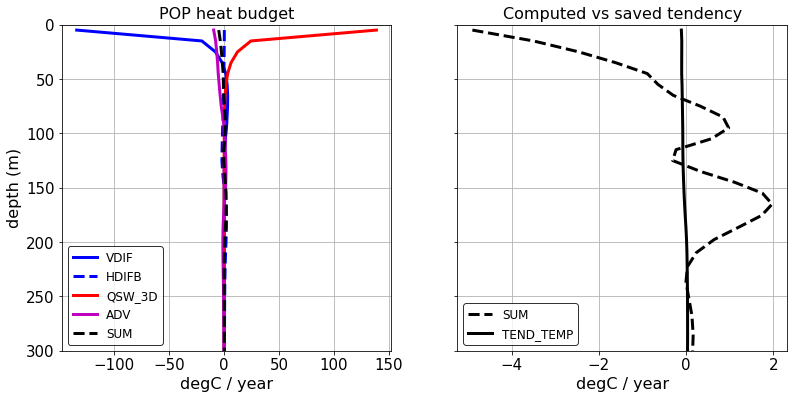

In [49]:
%%time

subset['z_t'] = ds.z_t / m2cm
total_rhs = subset.QSW_3D + subset.HDIF + subset.VDIF + subset.TOT_ADV 

ymin = 300

plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.rc('figure',titlesize=18)
mpl.rcParams['lines.linewidth'] = 3

fig, ax = plt.subplots(1, 2, figsize=(13, 6), sharey=True)

# plot individual components
plt.grid()
subset.VDIF.plot(y="z_t", ylim=(ymin, 0), color='b',label="VDIF", ax=ax[0])
subset.HDIF.plot(y="z_t", ylim=(ymin, 0), color='b',label="HDIFB",ls='--', ax=ax[0])
subset.QSW_3D.plot(y="z_t", ylim=(ymin, 0), color='r', label="QSW_3D", ax=ax[0])
subset.TOT_ADV.plot(y="z_t", ylim=(ymin, 0), color='m',label="ADV", ax=ax[0])
#subset.SUBMESO.plot(y="z_t", ylim=(ymin, 0), color='g',label="SUBM", ax=ax[0])
#subset.GM.plot(y="z_t", ylim=(ymin, 0), color='c',label="GM", ax=ax[0])
# plot sum
total_rhs.plot(y="z_t", ylim=(ymin, 0), color='k', label="SUM", ls="--", ax=ax[0] )
ax[0].grid(axis='both')
ax[0].set_title('POP heat budget',fontsize=16)
ax[0].set_xlabel('degC / year',fontsize=16)
ax[0].set_ylabel('depth (m)',fontsize=16)
leg=ax[0].legend(fontsize=12)
leg.get_frame().set_edgecolor('k')

# Compare sum of terms on RHS and TEND_TEMP (saved online)
plt.grid()
total_rhs.plot(y="z_t", ylim=(ymin, 0), color='k', label="SUM", ls="--", ax=ax[1] )
# plot tendency
subset.TEND_TEMP.plot(y="z_t", ylim=(ymin, 0), color='k', label="TEND_TEMP", ax=ax[1])
ax[1].grid(axis='both')
ax[1].set_title('Computed vs saved tendency',fontsize=16)
ax[1].set_xlabel('degC / year',fontsize=16)
ax[1].set_ylabel('',fontsize=16)
leg=ax[1].legend(fontsize=12,loc='lower left',edgecolor='k');
leg.get_frame().set_edgecolor('k')

fig.set_facecolor("w")